In [1]:
from myplt import *
efmt = dict(lw=3.5, capsize=7., capthick=1.5, elinewidth=1.5, fmt='o-') # for plt.errorbar() plot

mycms_o = [ cms.set_alpha(c, 1.0) for c in mycms ]
mycms2 = [
(1., 0., 0., 0.66),
(0.03, 0., 1., 0.67),
(0.5, 0, 0.65, 0.81),
(0., 0.54, 0.64, 0.71),
(0.96, 0.52, 0., 0.74),
(0.12, 0., 0.59, 0.85),
(0.51, 0.21, 0., 0.79),
(0., 0.33, 0.31, 1.0),
(0.01, 0.01, 0.01, 0.78)]
mycms2_o = [ cms.set_alpha(c, 1.0) for c in mycms2 ]
mycms2_r = [
(0.01, 0.01, 0.01, 0.78),
(1., 0., 0., 0.66),
(0.03, 0., 1., 0.67),
(0.5, 0, 0.65, 0.81),
(0., 0.54, 0.64, 0.71),
(0.96, 0.52, 0., 0.74),
(0.12, 0., 0.59, 0.85),
(0.51, 0.21, 0., 0.79),
(0., 0.33, 0.31, 1.0)]

# new settings
matplotlib.rc( 'lines', linewidth=3 )
matplotlib.rc( 'font', family='monospace', weight='normal', size=20 )

c_frame = (0,0,0,.8)
for tick in 'xtick', 'ytick':
    matplotlib.rc( tick+'.major', width=2.5, size=12)
    matplotlib.rc( tick+'.minor', width=1.5, size=4.5, visible=True )
    matplotlib.rc( tick, color=c_frame, labelsize=18, direction='in' )
matplotlib.rc( 'xtick', top=True )
matplotlib.rc( 'ytick', right=True )
matplotlib.rc( 'axes', linewidth=1.5, edgecolor=c_frame, labelweight='normal' )
matplotlib.rc( 'grid', color=c_frame )
matplotlib.rc( 'patch', edgecolor=c_frame )

In [2]:
class TimingChngSize:
    def __init__( self, base='./local/' ):
        self.type = [ 'formated', 'binary', 'h5', 'h5parallel', 'mpi' ]
        self.name = [ 'Formated', 'Native\ Binary', 'HDF5', r'HDF5\ Parallel\ (\times 4)', r'MPI\ Collective\ (\times 4)']
        
        data = []
        for t in self.type:
            d = np.loadtxt( base + t + '.timing', dtype=float )[1:]
            d[:, 0] /= 1024.0*1024.0
            v = d[:, 0] / d[:, 1]
            v1 = v - d[:, 0] / ( d[:, 1]+d[:, 2] )
            v2 = d[:, 0] / ( d[:, 1]-d[:, 2] ) - v
            v2[ v2 < 0. ] = 0.
            data.append(dict( 
                iosize=d[:, 0], throughput=v, err=(v1, v2)
            ))
        self.data = data

In [3]:
local = TimingChngSize( './local/' )
wkstat = TimingChngSize( './venus/' )
cls = TimingChngSize( './orion/' )
names_platform = [ 'Dell\ PC\ (Linux\,4.15)', 'Huawei\ WorkStat\ (Linux\,3.10)', 'Dell\ Cluster\ (Linux\,3.10)' ]

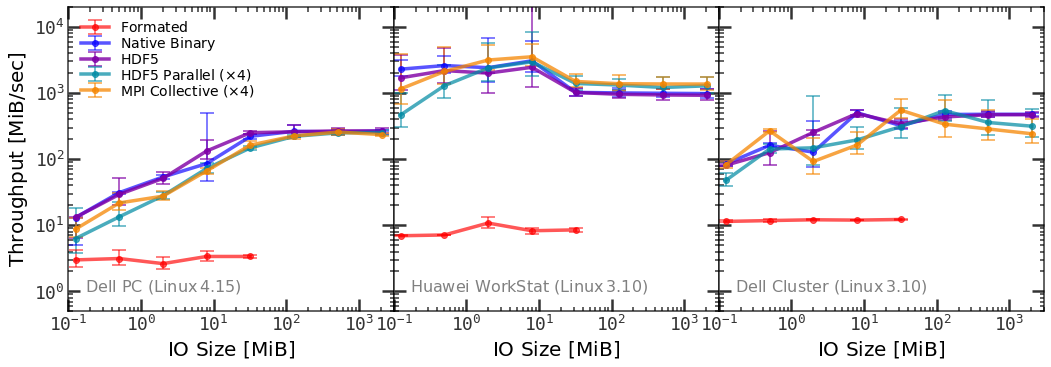

In [5]:
_, axs = m_get_figure( (15,5.5), 1,3 )
axs = axs[0]
plt.subplots_adjust( wspace=0., hspace=0. )

for iax, platform in enumerate((local, wkstat, cls)):
    ax = axs[iax]
    for i in range(5):
        d = platform.data[i]
        s = d['iosize']
        v = d['throughput']
        e1, e2 = d['err']
        if iax == 0:
            lab = { 'label': r'$\rm %s$'%(platform.name[i]) }
        else:
            lab = {}
        ax.errorbar( s, v, yerr=(e1,e2), c = mycms2[i], **efmt, **lab )

    m_set_scale(ax, 'log', 'log')
    m_set_lim(ax, [1.0e-1, 3.0e3], [0.5, 2.0e4])
    txpos( ax, r'$\rm %s$'%(names_platform[iax]), (.05, .08), 'gray' )
    m_set_label(ax, r'$\rm IO\ Size\ [MiB]$', r'$\rm Throughput\ [MiB/sec]$')
    
for ax in axs:
    ax.label_outer()
    
axs[0].legend(loc='upper left', fontsize=14, frameon = False, labelspacing=0., columnspacing=0.)
    
plt.tight_layout()
plt.subplots_adjust( wspace=0., hspace=0. )
plt.savefig('tune_iosize.pdf')
plt.savefig('tune_iosize.png')
plt.show()

In [6]:
class TimingChngParallel:
    def __init__( self, base='./local/' ):
        self.type = [ 'h5parallel', 'mpi' ]
        self.name = [ 'HDF5\ Parallel', 'MPI\ Collective']
        
        data = []
        for t in self.type:
            d = np.loadtxt( base + t + '.chnproc.timing', dtype=float )
            nproc, iosize, t, terr = d.T
            iosize /= 1024.0*1024.0
            v = iosize/t
            v1 = v - iosize/(t+terr)
            v2 = iosize/(t-terr) - v
            v2[ v2 < 0. ] = 0.
            data.append(dict( 
                iosize=iosize, throughput=v, err=(v1,v2), nproc=nproc
            ))
        self.data = data

In [7]:
local = TimingChngParallel( './local/' )
wkstat = TimingChngParallel( './venus/' )
cls = TimingChngParallel( './orion/' )
names_platform = [ 'Dell\ PC\ (Linux\,4.15)', 'Huawei\ WorkStat\ (Linux\,3.10)', 'Dell\ Cluster\ (Linux\,3.10)' ]

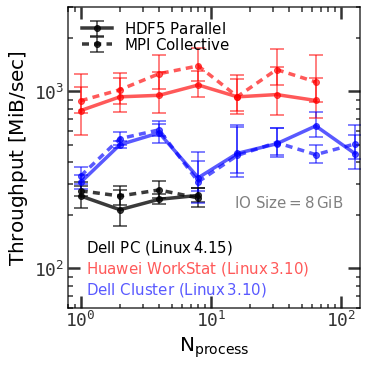

In [8]:
_, ax = m_get_figure( (5.5,5.5) )

for iax, platform in enumerate((local, wkstat, cls)):
    lst = [ '-', (0,(2,1.5)) ]
    for i in range(2):
        d = platform.data[i]
        nproc = d['nproc']
        v = d['throughput']
        e1, e2 = d['err']
        if iax == 0:
            lab = { 'label': r'$\rm %s$'%(platform.name[i]) }
        else:
            lab = {}
        ax.errorbar( nproc, v, yerr=(e1,e2), c = ([mycms2[-1]] + mycms)[iax], **efmt, **lab, linestyle=lst[i] )

m_set_scale(ax, 'log', 'log')
m_set_lim(ax, [0.8, 140], [6.0e1, 3.0e3])
#txpos( ax, r'$\rm %s$'%(names_platform[iax]), (.05, .08), 'gray' )
m_set_label(ax, r'$\rm N_{process}$', r'$\rm Throughput\ [MiB/sec]$')
    
ax.legend(loc='upper left', fontsize=15, frameon = False, labelspacing=0., columnspacing=0.)
for i in range(3):
    txpos( ax, r'$\rm %s$'%(names_platform[i]), (.06, .20-0.07*i), ([mycms[-1]]+mycms[:2])[i], 15 )
txpos( ax, r'$\rm IO\ Size=8\,GiB$', (.57, .35), 'gray', 15 )
    
plt.tight_layout()
plt.savefig('tune_parallel.pdf')
plt.savefig('tune_parallel.png')
plt.show()

In [9]:
class TimingChunk:
    def __init__( self, param='iosize' ):
        self.visitingpolicy = [ 'Random', 'Aligned', 'Localized' ]
        d = np.loadtxt( './local/chunk.'+param, dtype=float )
        self.param = param
        
        data = []
        for ip, p in enumerate(self.visitingpolicy):
            iosize, t, terr, blksize, cache, nslots, w0, _ = d[ip::3].T
            iosize /= 1024.0*1024.0
            blksize = 8.0*blksize*blksize / (8.0*32*32)
            cache /= 1024.0*1024.0
            
            v = iosize/t
            v1 = v - iosize/(t+terr)
            v2 = iosize/(t-terr) - v
            v2[ v2 < 0. ] = 0.
            data.append(dict( 
                throughput=v, err=(v1,v2), iosize=blksize, cache=cache, nslots=nslots, w0=w0
            ))
        self.data = data

In [10]:
iosize = TimingChunk( 'iosize' )
cache = TimingChunk( 'cache' )
nslots = TimingChunk( 'nslots' )
w0 = TimingChunk( 'w0' )
params = [ r'Chunk_{IO}/Chunk_{Storage}', r'Cache\ [MiB]', r'N_{slots}', r'w_0' ]

/home/yangyao/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


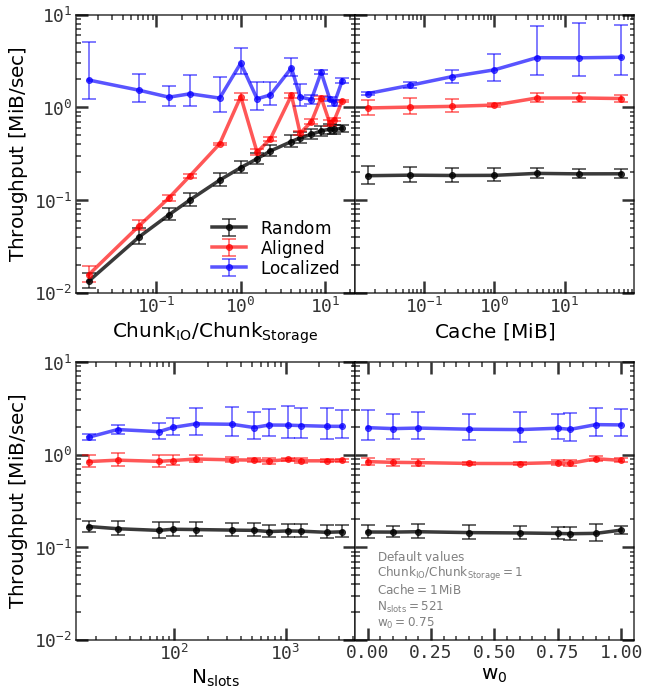

In [11]:
fig, axs = plt.subplots( 2,2,sharey=True, gridspec_kw={'wspace':0., 'hspace':.25}, figsize=(10,11.5) )
axs = axs.flat

for id, d in enumerate( (iosize,cache,nslots,w0) ):
    ax = axs[id]
    for ip in range(3):
        data = d.data[ip]

        x = data[d.param]
        v = data['throughput']
        e1, e2 = data['err']

        lab = dict( label=r'$\rm %s$'%( d.visitingpolicy[ip] ) )

        ax.errorbar( x, v, yerr=(e1,e2), c = mycms2_r[ip], **efmt, **lab )
    
    m_set_scale(ax, ('log' if id != 3 else 'linear' ), 'log')
    m_set_label(ax, r'$\rm %s$'%(params[id]) )
    if id in (0,2): m_set_label(ax, y=r'$\rm Throughput\ [MiB/sec]$' ) 
    m_set_lim(ax, y=[1.0e-2, 1.0e1])

axs[0].legend(loc='lower right', fontsize=17, frameon = False, labelspacing=0.)
txposs( axs[3], [ r'$\rm %s$'%s for s in (r'Default\ values', r'Chunk_{IO}/Chunk_{Storage}=1', 
                 r'Cache=1\,MiB', r'N_{slots}=521', r'w_0=0.75')], (.08, .30), (.0, -.06), ['gray']*5, 12 )

plt.tight_layout()
plt.savefig('tune_chunk.pdf')
plt.savefig('tune_chunk.png')
plt.show()